# Faster R-CNN 测试部分
在这部分中，我们利用在训练后得到的模型进行推理测试。

#### 安装与引用

In [1]:
!pip install torchvision==0.3
!pip uninstall -y protobuf
!pip install protobuf

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the 'pip install --upgrade pip' command.
Uninstalling protobuf-3.9.1:
  Successfully uninstalled protobuf-3.9.1
Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 1.2MB 56.0MB/s eta 0:00:01                      | 245kB 56.0MB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
# 将路径转入lib
import tools._init_paths

from model.config import cfg
from model.test import im_detect
from torchvision.ops import nms

from utils.timer import Timer
import matplotlib.pyplot as plt
import numpy as np
import os, cv2
import argparse

from nets.vgg16 import vgg16
from nets.resnet_v1 import resnetv1
from model.bbox_transform import clip_boxes, bbox_transform_inv

import torch


#### 参数定义

In [4]:
# PASCAL VOC类别设置
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')
# 网络模型文件名定义
NETS = {'vgg16': ('vgg16_faster_rcnn_iter_%d.pth',),'res101': ('res101_faster_rcnn_iter_%d.pth',)}
# 数据集文件名定义
DATASETS= {'pascal_voc': ('voc_2007_trainval',),'pascal_voc_0712': ('voc_2007_trainval+voc_2012_trainval',)}

#### 结果绘制函数

In [5]:
def vis_detections(im, class_dets, thresh=0.5):
    """Draw detected bounding boxes."""
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for class_name in class_dets:
        dets = class_dets[class_name]
        inds = np.where(dets[:, -1] >= thresh)[0]
        if len(inds) == 0:
            continue
        
        for i in inds:
            bbox = dets[i, :4]
            score = dets[i, -1]

            ax.add_patch(
                plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='red', linewidth=3.5)
                )
            ax.text(bbox[0], bbox[1] - 2,
                    '{:s} {:.3f}'.format(class_name, score),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')

        plt.axis('off')
        plt.tight_layout()
        plt.draw()


In [9]:
demonet = 'vgg16' # Network to use [vgg16 res101]
dataset = 'pascal_voc_0712' # Trained dataset [pascal_voc pascal_voc_0712]
im_file = "./tools/test.jpg"

trying to load weights from ./models/vgg16-voc0712/vgg16_faster_rcnn_iter_110000.pth
Loaded network ./models/vgg16-voc0712/vgg16_faster_rcnn_iter_110000.pth
(300, 21) (300, 84)
Detection took 0.080s for 300 object proposals


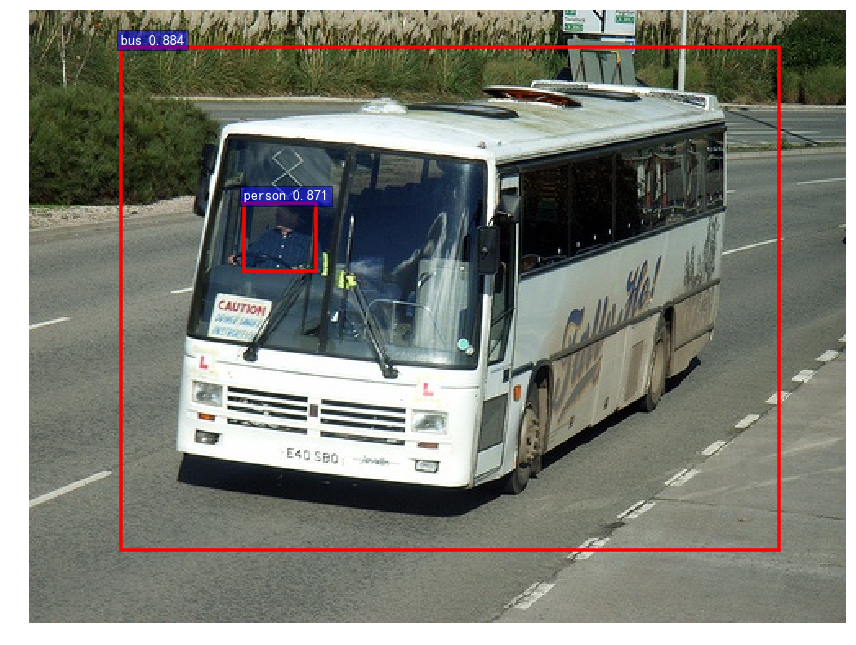

In [10]:

cfg.TEST.HAS_RPN = True  # Use RPN for proposals

# 模型存储位置
# 这里我们加载一个已经训练110000迭代之后的模型，可以选择自己的训练模型位置
saved_model = "./models/vgg16-voc0712/vgg16_faster_rcnn_iter_110000.pth"
print('trying to load weights from', saved_model)


# 加载backbone
net = vgg16()
# 构建网络
net.create_architecture(21, tag='default', anchor_scales=[8, 16, 32])
# 加载权重文件
net.load_state_dict(torch.load(saved_model, map_location=lambda storage, loc: storage))

net.eval()
# 选择计算设施
net.to(net._device)

print('Loaded network {:s}'.format(saved_model))


# 打开测试图片文件
im = cv2.imread(im_file)

# 定义计时器
timer = Timer()
timer.tic()
# 预测图片ROI
scores, boxes = im_detect(net, im)

print(scores.shape, boxes.shape)
timer.toc()
print('Detection took {:.3f}s for {:d} object proposals'.format(timer.total_time(), boxes.shape[0]))

# Visualize detections for each class
CONF_THRESH = 0.8
NMS_THRESH = 0.3

cls_dets = {}

# NMS 非极大值抑制操作
for cls_ind, cls in enumerate(CLASSES[1:]):
    cls_ind += 1 # because we skipped background
    cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_scores = scores[:, cls_ind]
    dets = np.hstack((cls_boxes,
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(torch.from_numpy(cls_boxes), torch.from_numpy(cls_scores), NMS_THRESH)
    dets = dets[keep.numpy(), :]

    if len(dets) > 0:
        if cls in cls_dets:
            cls_dets[cls] = np.vstack([cls_dets[cls], dets]) 
        else:
            cls_dets[cls] = dets
vis_detections(im, cls_dets, thresh=CONF_THRESH)

plt.show()
